# **YouTube Review Sentiment Analysis**

**MAIN TOPIC:** AI CONTROVERSY
**SUB-TOPICS:** Art, Music, Jobs, Programming, Cars

## **Setup**

### **Installing and Importing Libraries**

In [1]:
%pip install --upgrade google-api-python-client textblob nltk pandas matplotlib transformers python_dotenv langdetect spacy scikit-learn gensim vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [93]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [60]:
import os
import re
import json
import nltk
import spacy
import random
import warnings
import googleapiclient.errors
import googleapiclient.discovery

import numpy as np
import pandas as pd
import seaborn as sns
import langdetect as ld
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from dotenv import find_dotenv, load_dotenv

from tqdm import tqdm
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from IPython.core.display import display, HTML

from sklearn.manifold import TSNE
from sklearn.datasets import load_files
from sklearn.preprocessing import label_binarize
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

/var/folders/55/vxd0w9dx33d3t5dnclgnft5w0000gn/T/ipykernel_4746/1472451128.py:27: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### **Ignoring Warnings**

In [4]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## **Part A: Data Collection**

### **Setup**

#### YouTube API setup

In [96]:
load_dotenv(find_dotenv())

api_service_name = "youtube"
api_version = "v3"
developer_key = os.getenv("DEVELOPER_KEY")
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=developer_key)

# Print out key for sanity
# developer_key

### **Helper Functions**

#### Helper functions to retrieve and store video ids

In [97]:
# Gets video ids using the youtube api
def get_video_ids(topics : list, n_videos: int, n_buffer_videos: int = 0, min_comment_count : int = 0): 

    unique_video_ids = set()
    video_ids = {}

    for topic in topics:
        search_response = youtube.search().list(
            part="snippet",
            maxResults=n_videos + n_buffer_videos,
            order="relevance",
            q=topic,
            # type="video"
        ).execute()

        # print(json.dumps(search_response, indent=4))

        topic_video_ids = []
        response_video_ids = [item['id']['videoId'] for item in search_response['items'] if item['id']['kind'] == "youtube#video"]

        for video_id in response_video_ids:
            video_response = youtube.videos().list(
                part="snippet,statistics",
                id=video_id
            ).execute()

            video_items = video_response["items"][0]
            if "statistics" in video_items and "commentCount" in video_items["statistics"]:
                comment_count = int(video_response["items"][0]["statistics"]["commentCount"])
            else:
                comment_count = 0

            if comment_count > min_comment_count and video_id not in unique_video_ids and len(topic_video_ids) < n_videos:
                unique_video_ids.add(video_id)
                topic_video_ids.append(video_id)
        
        video_ids[topic] = topic_video_ids

    return video_ids

# Stores video ids into a json file
def write_video_ids(video_ids, file_path: str):
    with open(file_path, "w") as out_file: 
        json.dump(video_ids, out_file, indent=4) 

# Reads video ids from the json file
def read_video_ids(file_path: str):
    with open(file_path, "r") as in_file:
        video_ids = json.load(in_file)
    return video_ids

#### Helper functions to retrieve and store comments

In [98]:
# Gets video comments using the youtube api
def get_comments(video_ids: list, n_comments: int, n_buffer_comments: int = 0, lang_code: str = 'en'):

    video_comments = {}

    for video_id in video_ids:
        try:
            comments = []
            next_page_token = None

            while len(comments) < n_comments + n_buffer_comments:
                comments_response = youtube.commentThreads().list(
                    part="snippet", 
                    videoId=video_id, 
                    maxResults=n_comments + n_buffer_comments, 
                    order="relevance",
                    pageToken=next_page_token
                ).execute() # Fetch comments

                response_comments = [item['snippet']['topLevelComment']['snippet']['textDisplay'] for item in comments_response["items"]]

                for comment in response_comments:
                    try:
                        if ld.detect(comment) == lang_code and len(comments) < n_comments:
                            comments.append(comment)
                    except ld.LangDetectException:
                        # Handle the case where the language detection fails
                        pass

                next_page_token = comments_response.get("nextPageToken")
                if not next_page_token:
                    break
            
            video_comments[video_id] = comments

        except googleapiclient.errors.HttpError as e:
            print(f"Error processing video {video_id}: {e}")

    return video_comments

# Stores video comments into a json file
def write_video_comments(video_comments, file_path: str):
    with open(file_path, "w") as out_file: 
        json.dump(video_comments, out_file, indent=4) 

# Reads video comments from the json file
def read_video_comments(file_path: str):
    with open(file_path, "r") as in_file:
        video_comments = json.load(in_file)
    return video_comments

### **Main**

In order to automatically curate the videos, we define the 'topics' list below that contains the list of 6 topics we're interested in. This helps us get the most relevant videos by specifying the different parameters to filter and sort the results. Additionally, we store the extracted video ids into a json file to minimize the unessential usage of YouTube Data API.

In total: We extract 8 videos per topic, 6 topics in total. Moreover, we extract the top 250 comments per video.

In [99]:
# List of topic queries
topics = ["ai controversy", "ai taking over jobs", "self driving cars controversy", "ai music controversy", "ai art controversy", "ai programming controversy"]

In [100]:
# Extract videos on topic
if (os.path.exists("video_ids.json")):
    print("Reading video ids from file")
    video_ids = read_video_ids("video_ids.json")
else:
    print("Searching for videos using the API")
    video_ids = get_video_ids(topics, 10, 5, 250)
    write_video_ids(video_ids, "video_ids.json")

Reading video ids from file


In [101]:
video_ids = sum(read_video_ids("video_ids.json").values(), [])

# Retrieve comments for each video
if (os.path.exists("video_comments.json")):
    print("Reading comments from file")
    video_comments = read_video_comments("video_comments.json")
else:
    print("Retrieving comments using the API")
    video_comments = get_comments(video_ids, 250, 50)
    write_video_comments(video_comments, "video_comments.json")

Reading comments from file


## **Part B: Data Analysis, Selection and Labeling**

### **Helper Functions**

#### Helper functions to identify relevant comments and run BERT, VADER and TextBlob sentiment analyzers

In [102]:
NEGATIVE = -1
NEUTRAL = 0
POSITIVE = 1
RELEVANT = "relevant"
IRRELEVANT = "irrelevant"

In [103]:
def is_relevant_comment(comment, relevant_words): # Check if a comment contains any relevant words
    return any(re.search(r'\b' + re.escape(word) + r'\b', comment, re.IGNORECASE) for word in relevant_words) 

def bert(comment: str, sentiment_pipeline,  neutral_threshold: int):
    # Truncate comments to avoid exceeding the model's maximum token length
    truncated_comment = comment[:512] 
    result = sentiment_pipeline(truncated_comment)[0]
    label, score = result['label'], result['score']

    # Determine sentiment based on score threshold
    if score < neutral_threshold:
        polarity = NEUTRAL  # Neutral
    else:
        polarity = POSITIVE if label == 'POSITIVE' else NEGATIVE

    return polarity


def vader(comment: str, analyzer: SentimentIntensityAnalyzer):
    # Analyze the sentiment of the comment
    result = analyzer.polarity_scores(comment)
    compound_score = result['compound']

    # Determine sentiment based on compound score
    if compound_score >= 0.1:
        polarity = POSITIVE
    elif compound_score <= -0.1:
        polarity = NEGATIVE
    else:
        polarity = NEUTRAL

    return polarity


def run_sentiment_analyzer(analyzer: str, comments: list, relevant_words:list, sentiment_pipeline = None):

    labeled_comments = []
    for comment in comments:
        if is_relevant_comment(comment, relevant_words):
            match analyzer:
                case 'text_blob':
                    #print("Comment outside text_blob function:    ", comment)
                    polarity = TextBlob(comment).sentiment.polarity
                    polarity = POSITIVE if polarity > 0 else NEGATIVE if polarity < 0 else NEUTRAL
                case 'vader':
                    polarity = vader(comment, SentimentIntensityAnalyzer())
                case 'bert':
                    #print("Comment outside bert function:         ", comment)
                    polarity = bert(comment, sentiment_pipeline, neutral_threshold=0.55)
                case _:
                    raise Exception("Invalid or no analyzer provided")
            relevancy = RELEVANT
        else:
            polarity = NEUTRAL
            relevancy = IRRELEVANT

        labeled_comments.append({
            'relevance': relevancy,
            'text': comment,
            'polarity': polarity
        })

    return labeled_comments

### **Data Selection and Labeling**

In order to filter the most relevant comments, we curate a list of relevant keywords in order to identify comments that are relvant to our topic.
The keywords below are in the order of the following topics:
- AI Controversy
- AI taking over jobs
- Self-driving cars
- AI music controversy
- AI art controversy
- AI programming controversy

The keyword matching step helps us distinguish relevant comments from the irrelavant ones, thus helping in training our model more precisely.

In [104]:
# List of relevant words
relevant_words = ["ai", "controversy", "dilemma", "ethics", "ethical",
                  "job", "jobs", "industry", "industries", "work", "worker", "workers", "employment", "unemployment", 
                  "car", "cars" "drive", "drives", "driving", "self driving", "self-driving", "autonomous", "vehicle", "vehicles",
                  "music", "musician", "musicians", "compose", "composes", "composer", "composers", "composition", "compositions", "song", "songs", "sing", "sings", "singer", "singers", "singing", 
                  "art", "arts", "artwork", "artworks", "artist", "artists", "image", "images", "graphic", "graphics", "draw", "draws", "drawing", "paint", "painting", 
                  "code", "codes", "coding", "program", "programs", "programming", "language", "languages", "software", "developer", "developers", "development", "developments", "engineer", "engineers", "engineering"]

The above words are passed into the **run_sentiment_analyzer()** function in order to separate out irrelevent comments and assign them the **NEUTRAL** polarity. \
We do this as these comments should have no effect on the sentiment of the topic as a whole.

In order to label our dataset, we make use of TextBlob, VADER as well as BERT models. These models, specifically BERT is a state-of-the-art model, and the most advanced method for labelling.

In [105]:
all_comments_TB = []
all_comments_VADER = []
all_comments_BERT = []

sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
analyzer = SentimentIntensityAnalyzer()

# Run sentiment analysis on comments
for comment_list in video_comments.values():
    all_comments_TB.extend(run_sentiment_analyzer("text_blob", comment_list, relevant_words))
    all_comments_VADER.extend(run_sentiment_analyzer("vader", comment_list, relevant_words, analyzer))
    all_comments_BERT.extend(run_sentiment_analyzer("bert", comment_list, relevant_words, sentiment_pipeline))

# Convert to dataframes and remove duplicate comments
df_TB = pd.DataFrame(all_comments_TB).drop_duplicates(subset=['text'])
df_VADER = pd.DataFrame(all_comments_VADER).drop_duplicates(subset=['text']) 
df_BERT = pd.DataFrame(all_comments_BERT).drop_duplicates(subset=['text'])

df_TB.to_csv('TB_comments.csv', index=False)
df_VADER.to_csv('VADER_comments.csv', index=False)
df_BERT.to_csv('BERT_comments.csv', index=False)

In [106]:
# Reading the BERT, VADER and TB comments from a file to prevent regenerating the labels above
df_TB = pd.read_csv("TB_comments.csv")
df_VADER = pd.read_csv("VADER_comments.csv")
df_BERT = pd.read_csv("BERT_comments.csv")

As we can see below, BERT labeling as compared to Textblob and VADER gave more reasonable and accurate polarities to most of our comments. There are still a few comments where the assigned polarity is questionable but for the most part we found BERT to be better. Not to forget BERT is in-fact the State-of-the-art model.

**Hence, we decided to go ahead with the BERT labelling.**

In [107]:
pd.set_option('display.max_colwidth', None)

In [108]:
df_BERT_TB = pd.merge(df_BERT, df_TB, on=["text", "relevance"], suffixes=("_BERT", "_TB"))
df_BERT_TB

,relevance,text,polarity_BERT,polarity_TB
0,irrelevant,"on a lighter note, Merry Christmas my children :)",0,0
1,relevant,"&quot;If AI makes me an artist, then a microwave makes me a chef&quot;<br>- a wise internet artist",1,1
2,relevant,"What makes me most upset about this whole situation is how aggressively heartless people&#39;s reactions are. Not only do people not care, they celebrate the downfall of artists. It is said AI generated art lacks soul &amp; humanity... my dude, somewhere along the way society has ALREADY lost this",-1,1
3,relevant,"The irony of AI art bros is that they tell us artists to shut up and deal with it, but they cry about ppl stealing or mimmicing their AI art prompts. The hypocrisy is hilarious.",1,1
4,relevant,"I am not related to art, I was just researching ai art for business purposes, I&#39;ve heard that artists are not happy about it and wanted to know why, and stumbled upon your video. Thank you for putting it out there. It honestly blows my mind how people refuse to understand and empathize with your struggle, even if you aren&#39;t an artist, it&#39;s not freaking hard to imagine what it&#39;s like to spend years working on your craft and produce a lot things, and then have those things stolen and the fruits of your labour being used for profit by others. Disgusting. Why the hell would anyone push against you in this matter?<br>Dear artists, please value yourself, you are a gift to the world and your work is immensely valuable, keep fighting for yourselves. I&#39;m a regular person but I will take any chance that I get to speak for your benefit and do what I can to help.",1,-1
...,...,...,...,...
11432,relevant,These guys think no one has givern them code that wasnt assisted with Copilot at this stage? lol. Come on. They should know better.,-1,1
11433,relevant,"What hardware giveth, software taketh away. We have hardware 100x faster than previous generation, but all that allow is for the dev to be 100x lazier and the code 100x more unoptimized.",-1,1
11434,relevant,"I really like this take, and AI code review is amazingly something I have yet to see being implemented, despite AI getting pushed down our throat everywhere.<br>Why bother with getting the AI to write code for you, or why bother with AI generating your merge request text? It&#39;d be so much more useful if you let it run as a CI step and have it point out what it thinks are mistakes - cheap and instantaneous code reviews, with little risk involved since it&#39;s not gonna hallucinating code in critical areas",-1,1
11435,irrelevant,"More over, your brain also gets serial input, audio is serial, word is serial. &quot;Next word&quot; is a very good function approximator.",0,0


In [109]:
pd.set_option('display.max_colwidth', 50)

### **Splitting the Dataset**

Here we split the BERT-labeled dataset into a 80-20 train-test split and store them as separate **.csv** files

In [110]:
X, y = df_BERT[["relevance", "text"]], df_BERT["polarity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train.to_csv('data/yt_comments/train.csv', index=False)
test.to_csv('data/yt_comments/test.csv', index=False)

### **Initial Analysis using TextBlob and VADER**


In [111]:
Top_TB_comments = []
Top_VADER_comments = []

for video_id, comments in video_comments.items():
    # Extract the top 10 comments
    top_comments = comments[:10]
    for comment in top_comments:
        blob = TextBlob(comment).sentiment.polarity
        polarity_TB = POSITIVE if blob > 0 else NEGATIVE if blob < 0 else NEUTRAL

        vader = analyzer.polarity_scores(comment)['compound']
        polarity_VADER = POSITIVE if vader >= 0.1 else NEGATIVE if vader <= -0.1 else NEUTRAL

        Top_TB_comments.append({'text': comment, 'polarity': polarity_TB})
        Top_VADER_comments.append({'text': comment, 'polarity': polarity_VADER})

df_TB = pd.DataFrame(Top_TB_comments)
df_VADER = pd.DataFrame(Top_VADER_comments)

df_TB.to_csv('Test_TB_comments.csv', index=False)
df_VADER.to_csv('Test_VADER_comments.csv', index=False)

print("TextBlob: \n", df_TB.head(), "\n\n")
print("VADER: \n", df_VADER.head(), "\n")


TextBlob: 
                                                 text  polarity
0  on a lighter note, Merry Christmas my children :)         1
1  &quot;If AI makes me an artist, then a microwa...         1
2  What makes me most upset about this whole situ...         1
3  The irony of AI art bros is that they tell us ...         1
4  I am not related to art, I was just researchin...        -1 


VADER: 
                                                 text  polarity
0  on a lighter note, Merry Christmas my children :)         1
1  &quot;If AI makes me an artist, then a microwa...         1
2  What makes me most upset about this whole situ...        -1
3  The irony of AI art bros is that they tell us ...        -1
4  I am not related to art, I was just researchin...         1 



### **Loading the Dataset**

In [34]:
train = pd.read_csv('data/yt_comments/train.csv')
test = pd.read_csv('data/yt_comments/test.csv')

In [35]:
print(train.shape)
print(test.shape)

(9149, 3)
(2288, 3)


In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9149 entries, 0 to 9148
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   relevance  9149 non-null   object
 1   text       9149 non-null   object
 2   polarity   9149 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 214.6+ KB


In [115]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288 entries, 0 to 2287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   relevance  2288 non-null   object
 1   text       2288 non-null   object
 2   polarity   2288 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 53.8+ KB


### **Exploratory Data Analysis (EDA)**

In [116]:
train.head()

,relevance,text,polarity
0,relevant,im so happy we are making the most meaningful ...,-1
1,relevant,"Programmers created app, like : calculator, no...",-1
2,relevant,I’m not an artist but now I’m pretty mad at th...,-1
3,irrelevant,I don&#39;t think this would be possible yet i...,0
4,relevant,Women choosing to quit jobs and tend to home l...,-1


##### **Comment Distribution grouped by relevance**

Here we display the comment distribution grouped by **relevance**

In [117]:
temp = train.groupby('relevance').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Blues')

,relevance,text
1,relevant,5167
0,irrelevant,3982


<Axes: xlabel='relevance', ylabel='count'>

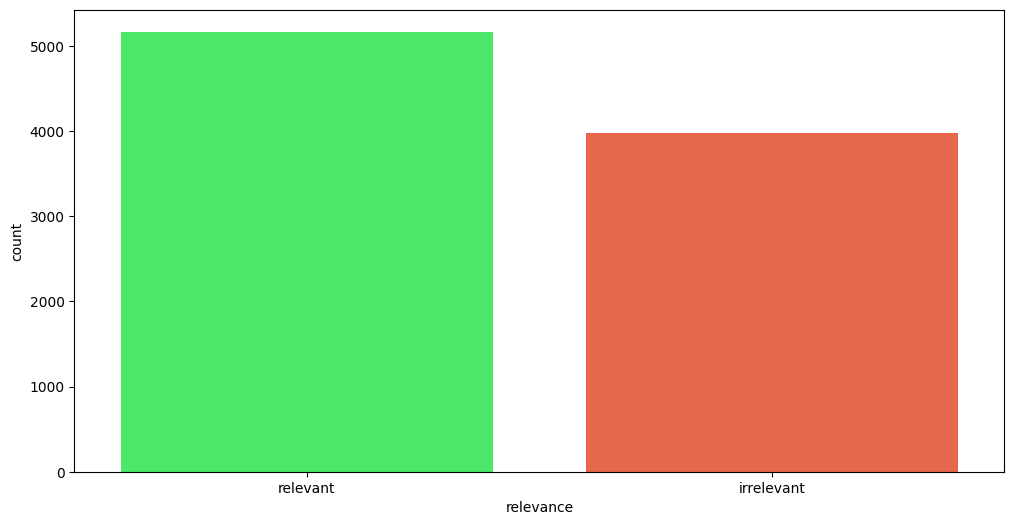

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
custom_palette = ['#33FF57', '#FF5733']
sns.countplot(x='relevance', data=train, palette=custom_palette)

We can see that there are more relevant comments than irrelevant

##### **Comment Distribution grouped by polarity**

Here we display the comment distribution grouped by **polarity**

In [119]:
temp = train.groupby('polarity').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Blues')

,polarity,text
1,0,4017
0,-1,3643
2,1,1489


<Axes: xlabel='polarity', ylabel='count'>

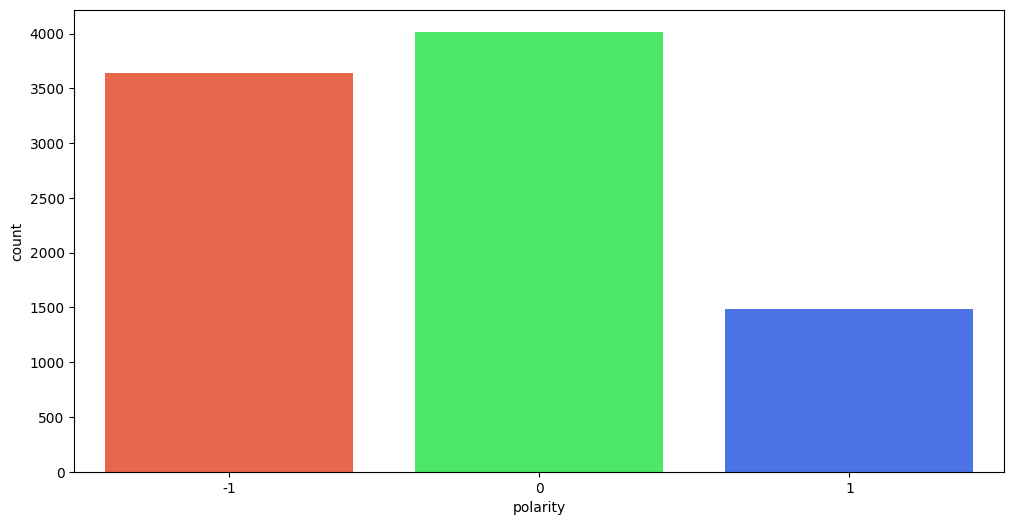

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
custom_palette = ['#FF5733', '#33FF57', '#3366FF']
sns.countplot(x='polarity', data=train, palette=custom_palette)

**Conclusions from the above experiments:**

We can see that there are more than twice as many negative comments as there are positive.\
We can also observe a large number of neutral comments. This is due to the the large number of irrelevant comments which were assigned **NEUTRAL** for the reasons stated above.

## **Part C: Text Analytics Pipeline**

### **Setup**

#### Loading the Dataset

In [5]:
train = pd.read_csv('data/yt_comments/train.csv')
test = pd.read_csv('data/yt_comments/test.csv')

#### Balancing the Dataset

In [6]:
X_train, X_test, y_train, y_test = train['text'], test['text'], train['polarity'], test['polarity']

In [7]:
# Separating out polarity classes
negative_class = train[train["polarity"] == -1]
neutral_class = train[train["polarity"] == 0]
positive_class = train[train["polarity"] == 1]

# Size of class with lowest count
class_size = min(len(negative_class), len(neutral_class), len(positive_class))

# Undersampling
negative_class_balanced = negative_class.sample(n=class_size, replace=True, random_state=42)
neutral_class_balanced = neutral_class.sample(n=class_size, replace=True, random_state=42)
positive_class_balanced = positive_class.sample(n=class_size, replace=True, random_state=42)

# Combining the three separate classes after undersampling
train_balanced = pd.concat([negative_class_balanced, neutral_class_balanced, positive_class_balanced])

# Reshuffling the balanced train set
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_balanced = train_balanced["text"]
y_train_balanced = train_balanced["polarity"]

#### Visualizing balanced train set

In [8]:
temp = train_balanced.groupby('polarity').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Blues')

,polarity,text
0,-1,1489
1,0,1489
2,1,1489


<Axes: xlabel='polarity', ylabel='count'>

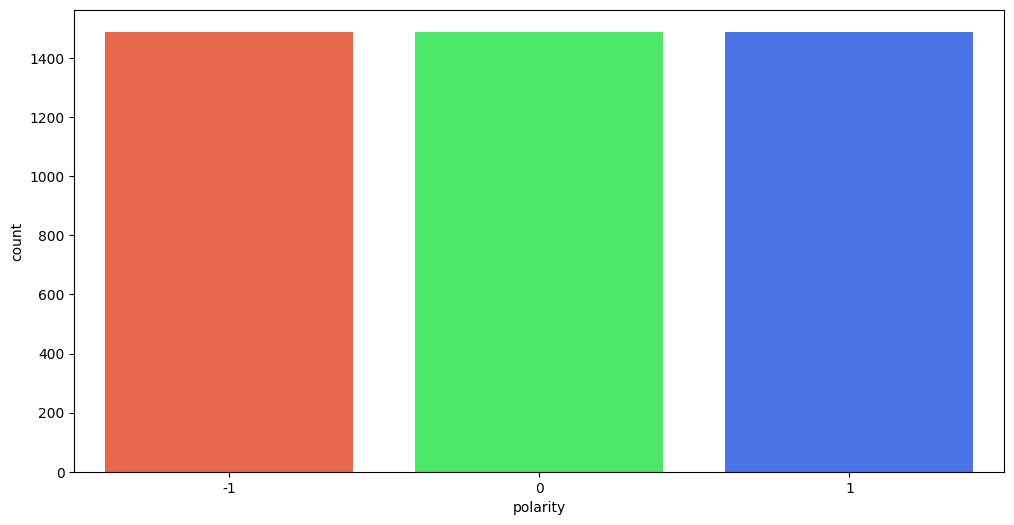

In [125]:
plt.figure(figsize=(12,6))
custom_palette = ['#FF5733', '#33FF57', '#3366FF']
sns.countplot(x='polarity', data=train_balanced, palette=custom_palette)

#### Converting train-test split from dataframe to list

In [131]:
X_train_balanced_list, y_train_balanced_list, X_test_list, y_test_list = X_train_balanced.tolist(), y_train_balanced.tolist(), X_test.tolist(), y_test.tolist()

### **Helper Functions**

## Data preprocessing

**As part of Text Processing, we perform Tokenization, Normalization (convert words to lower case), have Stop-word removal, and perform lemmatization and stemming below.**

##### Cleaning the text

In [134]:
EMOJI_PATTERN = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
  )

def clean_text(text):
    text_no_html = re.sub(r'<[^>]+>', ' ', text)
    text_no_links = re.sub(r'http\S+', '', text_no_html)
    text_no_timestamps = re.sub(r'\d{1,2}:\d{2}', '', text_no_links)
    text_no_emoji = re.sub(EMOJI_PATTERN, '', text_no_timestamps)
    replace_single_quotes = re.sub(r'&#39;', '\'', text_no_emoji)
    replace_double_quotes = re.sub(r'&quot;', '\"', replace_single_quotes)
    remove_mentions = re.sub(r'@\S*', '', replace_double_quotes)
    remove_whitespace = re.sub(r'\s+', ' ', remove_mentions)
    return remove_whitespace 

In [135]:
clean_text("Everything @JohnStossel puts out is QUALITY. Investigative Journalism with integrity keep on my friend!\n")

'Everything puts out is QUALITY. Investigative Journalism with integrity keep on my friend! '

##### Lemmatizing and stemming

In [136]:
en_nlp = spacy.load("en_core_web_sm")

def tokenize_text(text):
    doc = en_nlp(text)
    # Turn it into tokens, ignoring the punctuation
    return [token for token in doc if not token.is_punct]

In [137]:
tokenize_text('Everything puts out is QUALITY. Investigative Journalism with integrity keep on my friend! ')

[Everything,
 puts,
 out,
 is,
 QUALITY,
 Investigative,
 Journalism,
 with,
 integrity,
 keep,
 on,
 my,
 friend]

In [138]:
# defining stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/neilpatrao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [139]:
# define function that lemmatize using spacy
def lemmatize_spacy(text):
    cleaned_text = clean_text(text)
    # Convert those tokens into lemmas, EXCEPT the pronouns.
    tokens = [token.lemma_ if token.pos_ != 'PRON' else token.orth_ for token in tokenize_text(cleaned_text)]
    # remove stop words with NLTK and convert to lower case
    return [token.lower() for token in tokens if not token.lower() in stop_words]

In [140]:
lemmatize_spacy("I don't feel like having anything to eat!")

['feel', 'like', 'anything', 'eat']

In [141]:
def lemmatize_nltk(text):
    cleaned_text = clean_text(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w.norm_) for w in tokenize_text(cleaned_text)]
    # remove stop words with NLTK and convert to lower case
    return [token.lower() for token in tokens if not token.lower() in stop_words]

In [142]:
lemmatize_nltk("I don't feel like having ANYTHING to eat!")

['feel', 'like', 'anything', 'eat']

In [143]:
def stemmer_nltk(text):
    cleaned_text = clean_text(text)
    stemmer = nltk.PorterStemmer()
    tokens = [stemmer.stem(w.norm_) for w in tokenize_text(cleaned_text)]
    # remove stop words with NLTK and convert to lower case
    return [token.lower() for token in tokens if not token.lower() in stop_words]

In [144]:
stemmer_nltk("I don't feel like having anything to eat!")

['feel', 'like', 'anyth', 'eat']

##### Creating a custom transformer class for data preprocessing

In [145]:
class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, text_processor="lemmatize_nltk"):
        self.text_processor = text_processor

    def fit(self, X, y=None):
        return self

    def transform(self, X): 
        processed_texts = []
        for text in X:
            match self.text_processor:
                case "lemmatize_spacy":
                    token_list = lemmatize_spacy(text)
                case "lemmatize_nltk":
                    token_list = lemmatize_nltk(text)
                case "stemmer_nltk":
                    token_list = stemmer_nltk(text)
                case _:
                    raise Exception("Invalid or no text processor provided")
            processed_texts.append(token_list)
        return processed_texts

In [146]:
text_processor_lemma = TextProcessor('lemmatize_spacy')
processed_texts = text_processor_lemma.fit_transform(["Everything @JohnStossel puts out is QUALITY. Investigative Journalism with integrity keep on my friend!", "I don't feel like having anything to eat!"])

In [147]:
processed_texts

[['everything',
  'put',
  'quality',
  'investigative',
  'journalism',
  'integrity',
  'keep',
  'friend'],
 ['feel', 'like', 'anything', 'eat']]

In [106]:
processed_X_test = TextProcessor().fit_transform(X_test_list)

#### **Representation and Feature Extraction**

##### Create custom transformer class for vectorization-Word2Vec

In [149]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, processed_X_test=[], vector_size=300, window=5, min_count=1):
        self.processed_X_test = processed_X_test
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model_w2v = None

    def fit(self, X, y=None):
        file_path = "word2vec_model.bin"
        
        if os.path.exists(file_path):
            print(f"The file '{file_path}' exists.")
            # Load the Word2Vec model from the file
            self.model_w2v = Word2Vec.load(file_path)
        else:
            print(f"The file '{file_path}' does not exist.")
            # Train the Word2Vec model
            self.model_w2v = Word2Vec(X+self.processed_X_test, vector_size=self.vector_size, window=self.window, min_count=self.min_count)
            # Save the model to the file
            self.model_w2v.save(file_path)
        return self

    def transform(self, X):
        return [[0] * self.vector_size if not sentence else sum(self.model_w2v.wv[word] for word in sentence) / len(sentence) for sentence in X]

##### Visualising Word Embeddings

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

In [150]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels):
    random.seed(0)

    plt.figure(figsize=(8, 8))
    plt.scatter(x_vals, y_vals, s=10)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

def visualize_embeddings():
    model = Word2Vec.load("word2vec_model.bin")
    x_vals, y_vals, labels = reduce_dimensions(model)
    plot_with_matplotlib(x_vals, y_vals, labels)

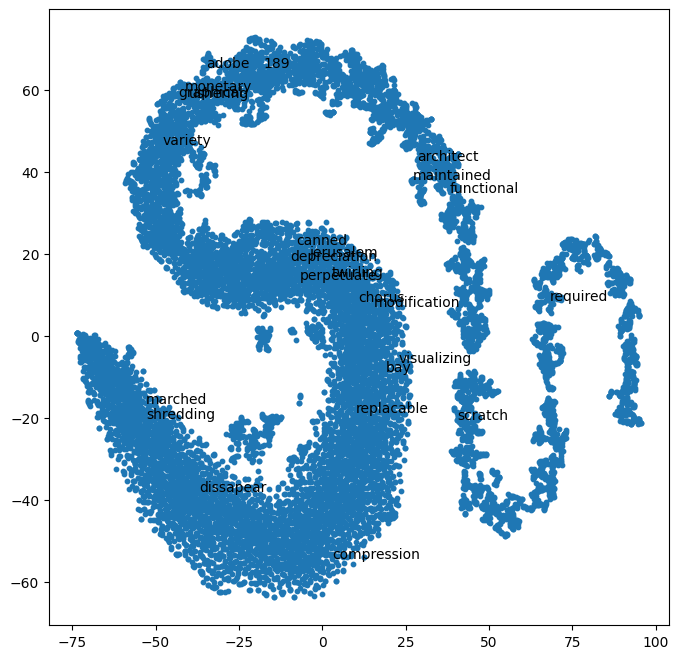

In [153]:
visualize_embeddings()

#### **Pipeline Creation**

In [35]:
def create_pipelines(names_list: list, step_list: list, classifier_list: list):
    steps = list(zip(names_list, step_list))
    # Create models for different types of classifiers
    models = []
    
    for classifier in classifier_list:
        model = steps.copy()
        model.append(('classifier', classifier))
        
        models.append(Pipeline(model))
    return models

#### **Evaluation**

In [11]:
# Displays the classification report
def display_cf_report(y_true, y_pred):
  cf_report = classification_report(y_true, y_pred)
  print("\nClassification Report:\n", cf_report)

Evaluation metrics function \
https://www.kaggle.com/code/jeffd23/10-classifier-showdown-in-scikit-learn

In [98]:
def compare_metrics_graph(log_df):
    sns.set_color_codes("muted")
    sns.barplot(x='Test Accuracy', y='Classifier', data=log_df, color="b")

    plt.xlabel('Test Accuracy %')
    plt.title('Classifier Accuracy')
    plt.show()

In [95]:
def plot_confusion_matrices(models, X_test, y_test, class_labels):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
    
    for model, ax in zip(models, axes.flatten()):
        ConfusionMatrixDisplay.from_estimator(model, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=class_labels)
        ax.title.set_text(model.named_steps['classifier'].__class__.__name__)
    plt.tight_layout()
    plt.show()

In [108]:
def evaluate_classifiers(models, X_train, y_train, X_test, y_test):
    log_cols=["Classifier", "Test Accuracy"]
    log = pd.DataFrame(columns=log_cols)

    for model in models:
        model_name = model.named_steps['classifier'].__class__.__name__
        model.fit(X_train, y_train)

        print(f"Results for {model_name} model:\n")

        print(f"Model: {model}\n")

        y_pred_train = model.predict(X_train)
        score_train = accuracy_score(y_train, y_pred_train)
        print(f"Accuracy on train set: {score_train:0.3f}")
        
        y_pred_test = model.predict(X_test)
        score_test = accuracy_score(y_test, y_pred_test)
        print(f"Accuracy on test set: {score_test:0.3f}")

        display_cf_report(y_test, y_pred_test)
    
        log_entry = pd.DataFrame([[model.named_steps['classifier'].__class__.__name__, score_test*100]], columns=log_cols)
        log = pd.concat([log, log_entry])

    class_labels = ["Negative", "Neutral", "Positive"]

    plot_confusion_matrices(models, X_test, y_test, class_labels)
    
    compare_metrics_graph(log)

### **Models**

#### **Count Vectorizer Models**

In [109]:
name_list1 = ['count_vectorizer']
step_list1 = [CountVectorizer(tokenizer= lemmatize_spacy,min_df=5)]
classifier_list1 = [LogisticRegression(), SVC(), MultinomialNB(), SGDClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]
models1 = create_pipelines(name_list1, step_list1, classifier_list1)

Results for LogisticRegression model:

Model: Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x2868bbce0>)),
                ('classifier', LogisticRegression())])

Accuracy on train set: 0.500
Accuracy on test set: 0.200

Classification Report:
               precision    recall  f1-score   support

          -1       0.20      1.00      0.33         2
           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         2

    accuracy                           0.20        10
   macro avg       0.07      0.33      0.11        10
weighted avg       0.04      0.20      0.07        10

Results for SVC model:

Model: Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x2868bbce0>)),
                ('classifier', SVC())])

Accuracy on train set: 0.50

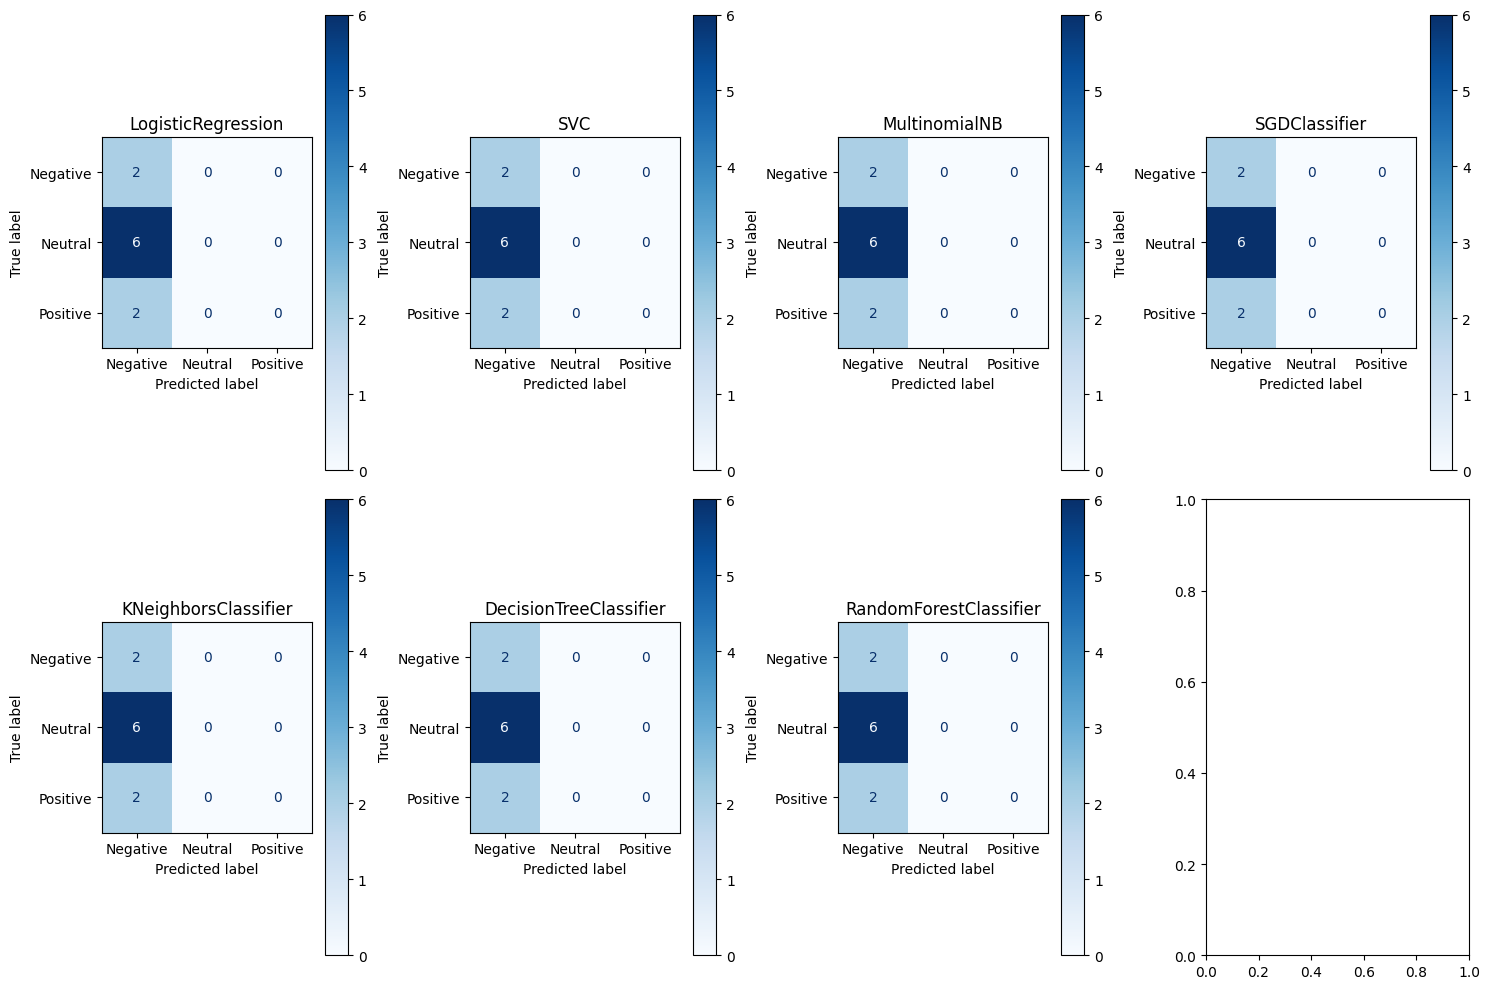

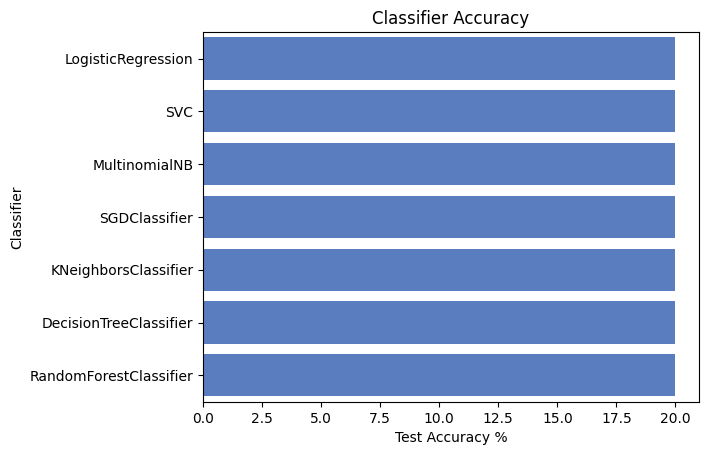

In [110]:
evaluate_classifiers(models1, X_train_balanced_list, y_train_balanced_list, X_test_list, y_test_list)

### **Text Processor + Word2Vec Vectorizer Models**

In [72]:
name_list2 = ['text_processor', 'w2v_vectorizer']
step_list2 = [TextProcessor(), Word2VecVectorizer(processed_X_test)]
classifier_list2 = [LogisticRegression(), SVC(), GaussianNB(), SGDClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]
models2 = create_pipelines(name_list2, step_list2, classifier_list2)

In [73]:
evaluate_classifiers(models2, X_train_balanced_list, y_train_balanced_list, X_test_list, y_test_list)

The file 'word2vec_model.bin' exists.
Accuracy of Pipeline(steps=[('text_processor', TextProcessor()),
                ('w2v_vectorizer',
                 Word2VecVectorizer(processed_X_test=[[' ', 'actually', 'felt',
                                                       'better', 'film',
                                                       'cry'],
                                                      ['corporation', 'create',
                                                       'database', 'like',
                                                       'address', 'book',
                                                       'scrapping', 'data',
                                                       'corporation', 'owns',
                                                       'copyright', 'human',
                                                       'authorship'],
                                                      ['irony', 'terraforming',
                                    

ValueError: Negative values in data passed to MultinomialNB (input X)

### **TF-IDF Vectorizer Models**

In [76]:
name_list3 = ['tfidf_vectorizer']
step_list3 = [TfidfVectorizer(tokenizer= lemmatize_spacy,min_df=5)]
classifier_list3 = [LogisticRegression(), SVC(), MultinomialNB(), SGDClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]
models3 = create_pipelines(name_list3, step_list3, classifier_list3)

c:\Users\HanaS\anaconda3\envs\f21aa\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', LogisticRegression())]) with train dataset is: 0.925
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', LogisticRegression())]) with test dataset is: 0.771


c:\Users\HanaS\anaconda3\envs\f21aa\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', SVC())]) with train dataset is: 0.993
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', SVC())]) with test dataset is: 0.787


c:\Users\HanaS\anaconda3\envs\f21aa\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', MultinomialNB())]) with train dataset is: 0.827
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', MultinomialNB())]) with test dataset is: 0.620


c:\Users\HanaS\anaconda3\envs\f21aa\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', SGDClassifier())]) with train dataset is: 0.957
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', SGDClassifier())]) with test dataset is: 0.738


c:\Users\HanaS\anaconda3\envs\f21aa\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', KNeighborsClassifier())]) with train dataset is: 0.465
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', KNeighborsClassifier())]) with test dataset is: 0.435


c:\Users\HanaS\anaconda3\envs\f21aa\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', DecisionTreeClassifier())]) with train dataset is: 1.000
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', DecisionTreeClassifier())]) with test dataset is: 0.733


c:\Users\HanaS\anaconda3\envs\f21aa\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', RandomForestClassifier())]) with train dataset is: 1.000
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000001E1258062A0>)),
                ('classifier', RandomForestClassifier())]) with test dataset is: 0.806


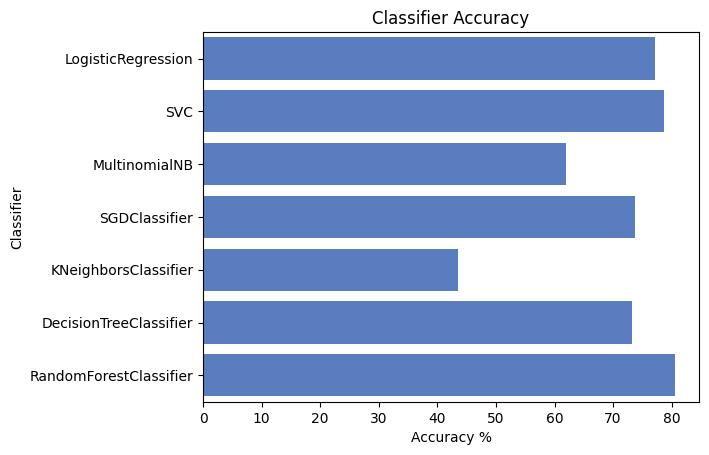

In [77]:
evaluate_classifiers(models3, X_train_balanced_list, y_train_balanced_list, X_test_list, y_test_list)

In [ ]:
# name_list4 = ['tfidf_vectorizer']
# step_list4 = [TfidfVectorizer(tokenizer= lemmatize_spacy,min_df=5)]
# classifier_list3 = [LogisticRegression(), SVC(), MultinomialNB(), SGDClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]
# models3 = create_pipelines(name_list3, step_list3, classifier_list3)

## Hyperparameter tuning

In [43]:
name_list4 = ['tfidf_vectorizer']
step_list4 = [TfidfVectorizer(tokenizer= lemmatize_spacy,min_df=5, max_df=0.75, ngram_range=(2, 2))]
classifier_list4 = [LogisticRegression(C=0.01), LogisticRegression(C=0.1),LogisticRegression(C=0.001)]
models4 = create_pipelines(name_list4, step_list4, classifier_list4)

Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(2, 2),
                                 tokenizer=<function lemmatize_spacy at 0x000002B1C1F2FD80>)),
                ('classifier', LogisticRegression(C=0.01))]) with train dataset is: 0.729
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(2, 2),
                                 tokenizer=<function lemmatize_spacy at 0x000002B1C1F2FD80>)),
                ('classifier', LogisticRegression(C=0.01))]) with test dataset is: 0.621
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(2, 2),
                                 tokenizer=<function lemmatize_spacy at 0x000002B1C1F2FD80>)),
                ('classifier', LogisticRegression(C=0.1))]) with train dataset is: 0.771
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfV

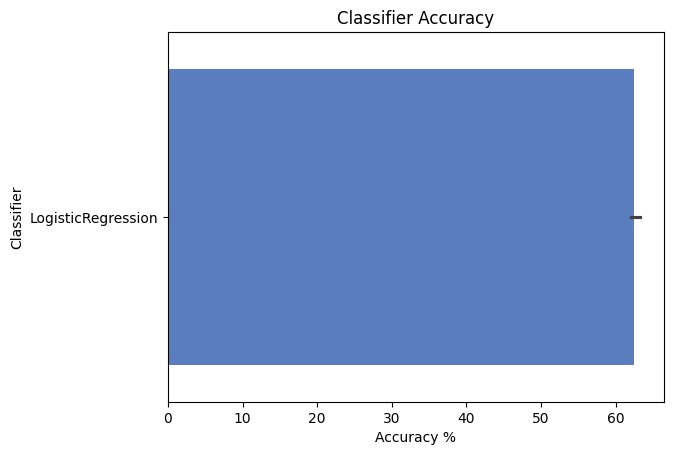

In [41]:
evaluate_classifiers(models4, X_train_balanced_list, y_train_balanced_list, X_test_list, y_test_list)

In [44]:
name_list5 = ['tfidf_vectorizer']
step_list5 = [TfidfVectorizer(tokenizer= lemmatize_spacy,min_df=5, max_df=0.75, ngram_range=(1, 1))]
classifier_list5 = [LogisticRegression(C=0.01), LogisticRegression(C=0.1),LogisticRegression(C=0.001)]
models5 = create_pipelines(name_list5, step_list5, classifier_list5)

Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.75, min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000002B1C1F2FD80>)),
                ('classifier', LogisticRegression(C=0.01))]) with train dataset is: 0.741
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.75, min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000002B1C1F2FD80>)),
                ('classifier', LogisticRegression(C=0.01))]) with test dataset is: 0.750
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.75, min_df=5,
                                 tokenizer=<function lemmatize_spacy at 0x000002B1C1F2FD80>)),
                ('classifier', LogisticRegression(C=0.1))]) with train dataset is: 0.813
Accuracy of Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.75, min_df=5,
                           

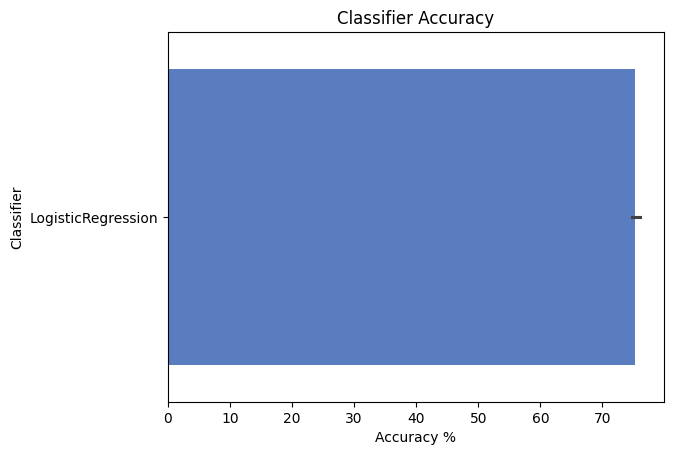

In [45]:
evaluate_classifiers(models5, X_train_balanced_list, y_train_balanced_list, X_test_list, y_test_list)

<Axes: xlabel='relevance', ylabel='count'>

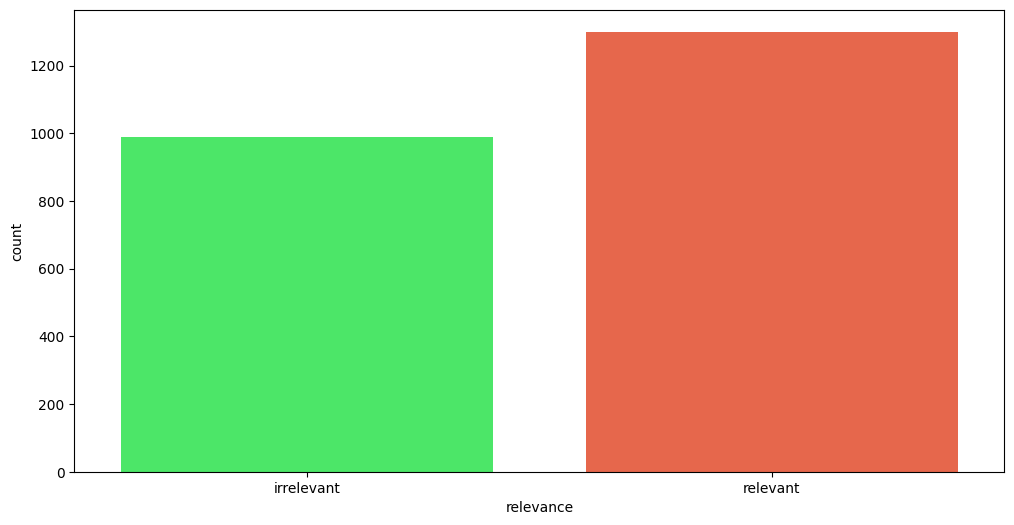

In [46]:
plt.figure(figsize=(12,6))
custom_palette = ['#33FF57', '#FF5733']
sns.countplot(x='relevance', data=test, palette=custom_palette)

<Axes: xlabel='polarity', ylabel='count'>

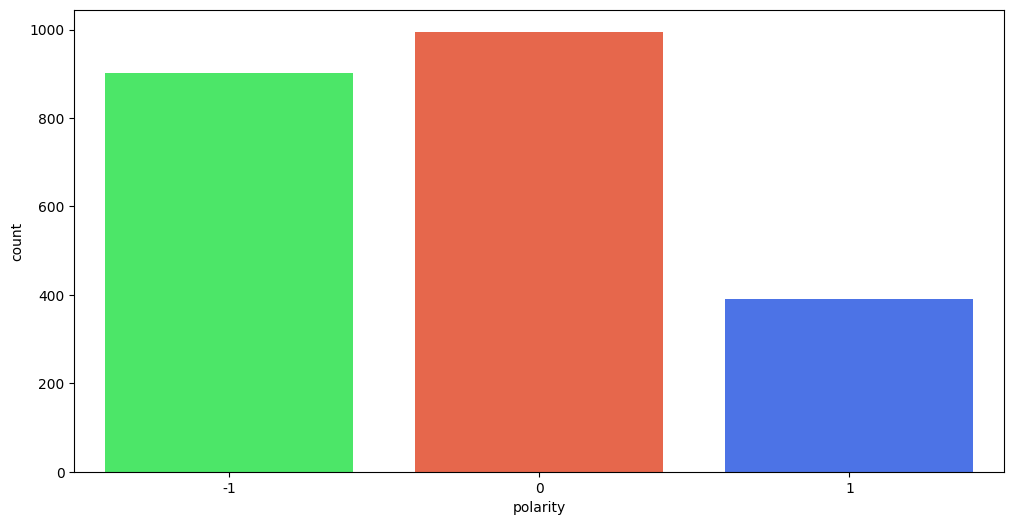

In [59]:
plt.figure(figsize=(12,6))
custom_palette = ['#33FF57', '#FF5733', '#3366FF']
sns.countplot(x='polarity', data=test, palette=custom_palette)

In [48]:
best_model = Pipeline([('tfidf_vectorizer', TfidfVectorizer(max_df=0.75, min_df=5,tokenizer=lemmatize_spacy, ngram_range=(1, 1))), ('classifier', LogisticRegression(C=0.1))])

In [50]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test_list)

Accuracy score for the best model:  0.7534965034965035


In [51]:
print("Accuracy score for the best model: ", accuracy_score(y_test_list, y_pred)*100)

Accuracy score for the best model:  75.34965034965036


In [57]:
pred_df = pd.concat([X_test, pd.DataFrame(y_pred, columns=["polarity"])], axis=1, )

In [58]:
pred_df

,text,polarity
0,👏 👏 that actually felt better than most of fil...,0
1,A corporation can create a database like an ad...,0
2,The irony is that Terraforming Mars was strugg...,0
3,except whom will the pizza shop sell their imp...,0
4,"I love <a href=""https://www.youtube.com/watch?...",0
...,...,...
2283,My guess is that AI music will be very popular...,-1
2284,<b>*Lightning McQueen has entered the chat*</b>,0
2285,Oof you know they&#39;ve been in a lot of acci...,0
2286,"Making something woke is like the Midas touch,...",0
